# HW 6
-- Serat Saad

In [225]:
# import block
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture, aperture_photometry
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import ccdproc as ccdp
from convenience_function import show_image
from astropy.stats import mad_std
from astropy.table import Table
from photutils.aperture import DAOStarFinder, CircularAperture, aperture_photometry, CircularAnnulus
from astropy.stats import mad_std
import numpy as np
from astropy.visualization import simple_norm
from ccdproc import ImageFileCollection

In [213]:
data_dir = 'Imaging/'            # raw data directory
reduced_dir = 'Imaging.reduced/' # reduced working directory

CCD Linearity test:
    
For the linearity test I went through the files in the log marked as "linearity test." The I founf both mean and median adu for all the files and then plotted that median/mean against exposure time found from the log file.


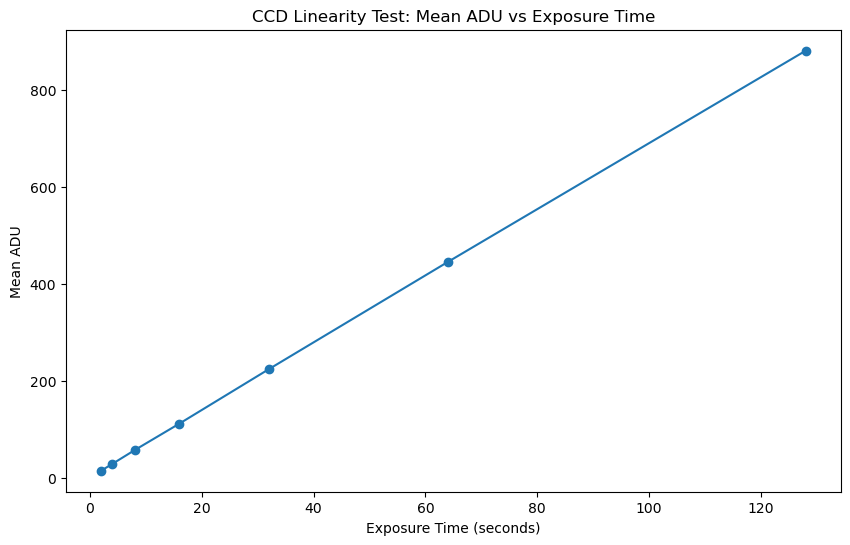

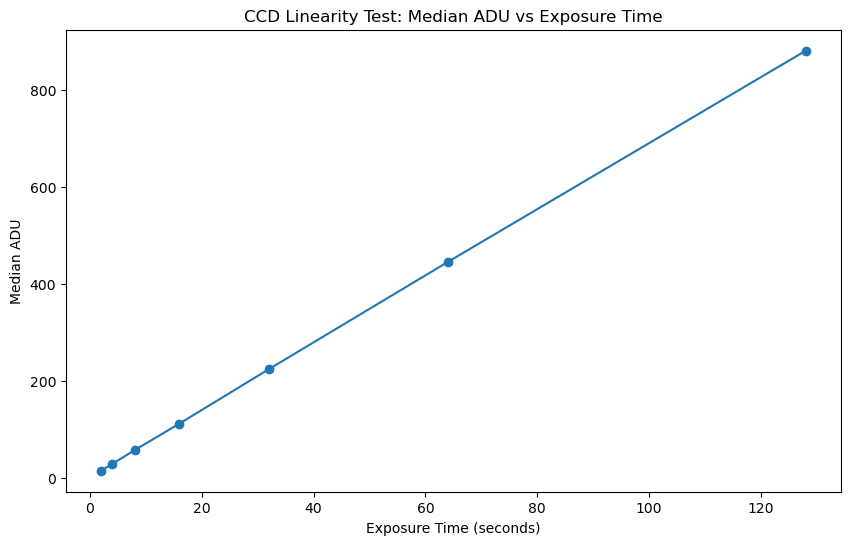

In [214]:
fits_files = ['Imaging.reduced/a074otzf.fits', 'Imaging.reduced/a075otzf.fits', 'Imaging.reduced/a076otzf.fits', 
              'Imaging.reduced/a077otzf.fits', 'Imaging.reduced/a078otzf.fits', 'Imaging.reduced/a079otzf.fits', 
              'Imaging.reduced/a080otzf.fits']

exposure_times = [2, 4, 8, 16, 32, 64, 128]

mean_adus = []
median_adus = []

for file in fits_files:
    # Open the FITS file
    with fits.open(file) as hdul:
        # Extract the data from the first (primary) HDU
        data = hdul[0].data

        # Find the median and mean ADU value in the data
        mean_adu = np.mean(data)
        median_adu = np.median(data)
        mean_adus.append(mean_adu)

# We can create a plot of Mean ADU vs. Exposure Time
plt.figure(figsize=(10, 6))
plt.plot(exposure_times, mean_adus, marker='o', linestyle='-')
plt.xlabel('Exposure Time (seconds)')
plt.ylabel('Mean ADU')
plt.title('CCD Linearity Test: Mean ADU vs Exposure Time')

plt.show()

# We can create a plot of Median ADU vs. Exposure Time
plt.figure(figsize=(10, 6))
plt.plot(exposure_times, mean_adus, marker='o', linestyle='-')
plt.xlabel('Exposure Time (seconds)')
plt.ylabel('Median ADU')
plt.title('CCD Linearity Test: Median ADU vs Exposure Time')

plt.show()


In both of these cases (mean and median), we can see a linear relation between the exposure time and the median.

I picked up a random file, chose three stars randomly, keeping in mind that one source should be faint, one should be medium bright, and the other should be bright. Then found the background level nois by choosing 

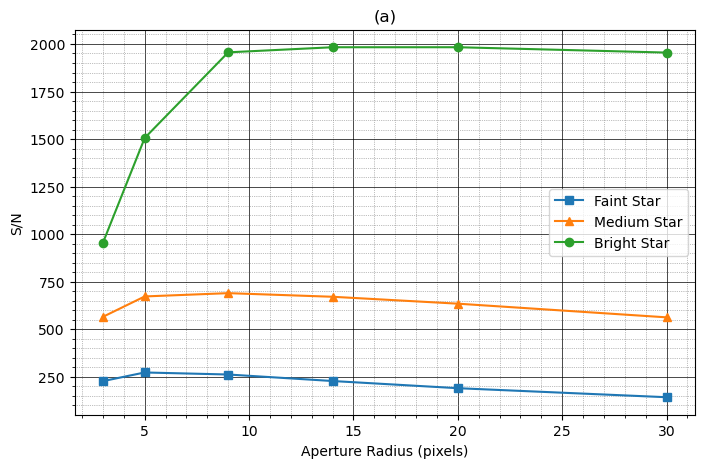

In [5]:
with fits.open("Imaging.reduced/a085otzf.fits") as hdul:
    data = hdul[0].data

# Define positions of three stars (faint, medium, bright)
x1 = 824.6
x2 = 1350.2
x3 = 495.689

y1 = 1089.8
y2 = 840.2
y3 = 1471.1

positions = [(x1,y1),(x2,y2),(x3,y3)]

# Calculating background level and noise
background_region = data[950:980, 1086:1140]  # Defining a region with no stars
mean, median, std = sigma_clipped_stats(background_region)

# Defining a range of aperture sizes
aperture_sizes = [3, 5, 9, 14, 20, 30]


# Now performing photometry to calculate the S/N
sn_data = {'faint': [], 'medium': [], 'bright': []}
for r in aperture_sizes:
    apertures = CircularAperture(positions, r=r)
    phot_table = aperture_photometry(data, apertures)
    for i, star in enumerate(['faint', 'medium', 'bright']):
        signal = phot_table['aperture_sum'][i] - median * apertures.area
        noise = np.sqrt(signal + std**2 * apertures.area)
        sn = signal / noise
        sn_data[star].append(sn)

# Plotting S/N vs aperture radius
fig, ax = plt.subplots(figsize=(8, 5))
markers = ['s', '^', 'o'] 

ax.plot(aperture_sizes, sn_data['faint'], marker=markers[0], linestyle='-', label='Faint Star')
ax.plot(aperture_sizes, sn_data['medium'], marker=markers[1], linestyle='-', label='Medium Star')
ax.plot(aperture_sizes, sn_data['bright'], marker=markers[2], linestyle='-', label='Bright Star')


ax.set_xlabel('Aperture Radius (pixels)')
ax.set_ylabel('S/N')
ax.set_title('S/N vs Aperture Radius') 
ax.legend()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

plt.show()

We need to pick up the best S/N based on the peak of these plots. It seems like an Aperture Radius of 5, 9, and 15 would be the best to be picked for faint, medium, and bright stars.

To identify the standard stars, an approach can be to calbrate the pixel in the image with the coordiantes in the sky. I used astrometry.net to calibrate. It returned me a wcs header file that can be used to get the pixel value of the targetted coordinates.

From the Landolt (1992) papers I found the list of standard stars along with their coordinates. The list is given below:


![Alt text](landolt_table.png)


Now I used DAO find to find out the pixel of these images and then I plotted an aperture around them to identify it in the image frame. At first I used astrometry.net to find out the pixel to coordinate relation, then I manually decided the region where the standard stars lies in. Then I fixed that pixel region and found the top 5 bright stars in that region, which are eventually the five standard stars from Landolt(1992) paper. I also plotted them in the following cell so that we can see which stars we are choosing.

 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
294    989.81904846515 ...  370.3378238436534  -6.421495175665722
292 1045.7403809276445 ...  66.99774742440862 -4.5651505031104636
339  1252.516590478197 ...  451.6216301420206 -6.6369368350497435
343 1364.8571061505368 ...   372.345978799913  -6.427366669958753
328 1444.8412057549529 ... 382.17064408342407 -6.4556433106552795


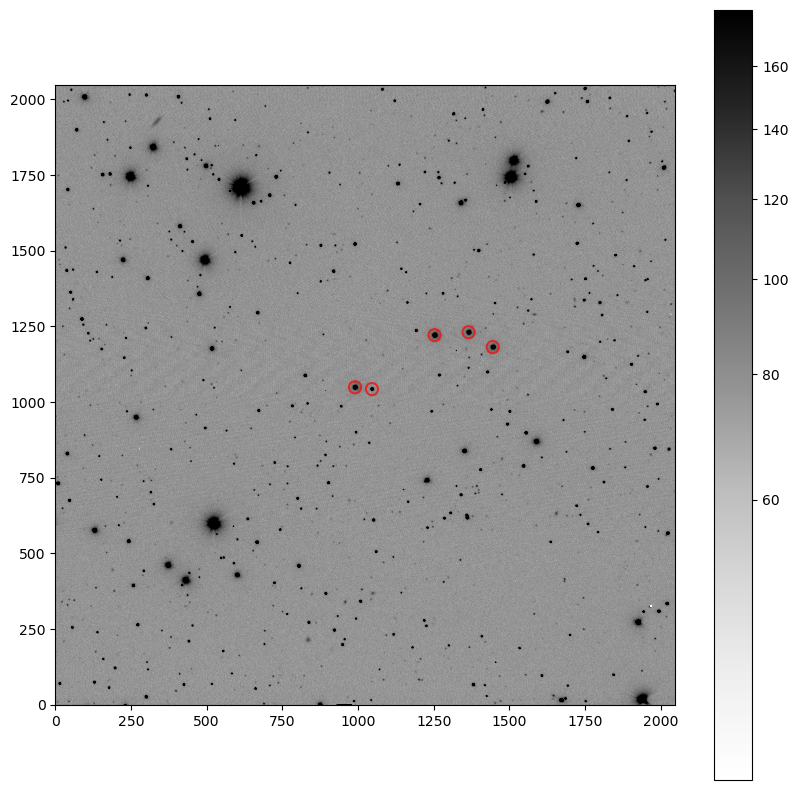

In [260]:
hdu = fits.open('Imaging.reduced/a083otzf.fits')
data = hdu[0].data
hdu.close()

background_noise = mad_std(data)
daofind = DAOStarFinder(fwhm=2.0, threshold=5*background_noise)
sources = daofind(data - np.median(data))

# Filtering sources based on the x and y coordinate range where the posible standard stars can be
x_min, x_max = 750, 1500
y_min, y_max = 900, 1300
filtered_sources = sources[(sources['xcentroid'] > x_min) & (sources['xcentroid'] < x_max) & 
                           (sources['ycentroid'] > y_min) & (sources['ycentroid'] < y_max)]

filtered_sources.sort('mag')


# Calculating pairwise distances between sources so that I don't select same region twice
x = np.array(filtered_sources['xcentroid'])
y = np.array(filtered_sources['ycentroid'])
distances = np.sqrt((x[:, np.newaxis] - x[np.newaxis, :])**2 + (y[:, np.newaxis] - y[np.newaxis, :])**2)

min_distance = 500

unique_sources = Table(names=filtered_sources.colnames)
for i, source in enumerate(filtered_sources):
    if not np.any((distances[i] < min_distance) & (distances[i] > 0)):
        unique_sources.add_row(source)


filtered_sources = filtered_sources[:5]
filtered_sources.sort('xcentroid')

print(filtered_sources)

# Drawing aperture around the sources to identify them in the plot

aperture_radius = 20
positions = np.transpose((filtered_sources['xcentroid'], filtered_sources['ycentroid']))
apertures = CircularAperture(positions, r=aperture_radius)

plt.figure(figsize=(10, 10))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, cmap='Greys', origin='lower', norm=norm)
apertures.plot(color='red', lw=1.5, alpha=0.7)
plt.colorbar()
plt.show()

In the following cell, I tried to make the whole thing as a tool (in two separate functions). One function will filter the standard stars, another function will calculate the instrumental magnitude for the stars.

In [282]:
def filter_sources(data, x_min, x_max, y_min, y_max, fwhm=3.0, threshold_factor=5):
    """
    Detects sources in the image data and filters them based on specified x and y range.
    """
    background_noise = mad_std(data)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold_factor * background_noise)
    sources = daofind(data - np.median(data))
    filtered_sources = sources[(sources['xcentroid'] > x_min) & (sources['xcentroid'] < x_max) &
                               (sources['ycentroid'] > y_min) & (sources['ycentroid'] < y_max)]

    background_noise = mad_std(data)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold_factor*background_noise)
    sources = daofind(data - np.median(data))
    filtered_sources = sources[(sources['xcentroid'] > x_min) & (sources['xcentroid'] < x_max) & 
                               (sources['ycentroid'] > y_min) & (sources['ycentroid'] < y_max)]
    
    filtered_sources.sort('mag')
    
    
    # Calculating pairwise distances between sources so that I don't select same region twice
    x = np.array(filtered_sources['xcentroid'])
    y = np.array(filtered_sources['ycentroid'])
    distances = np.sqrt((x[:, np.newaxis] - x[np.newaxis, :])**2 + (y[:, np.newaxis] - y[np.newaxis, :])**2)
    
    min_distance = 500
    
    unique_sources = Table(names=filtered_sources.colnames)
    for i, source in enumerate(filtered_sources):
        if not np.any((distances[i] < min_distance) & (distances[i] > 0)):
            unique_sources.add_row(source)
    
    
    filtered_sources = filtered_sources[:5]
    
    filtered_sources.sort('xcentroid')
    
    

    return filtered_sources[:5]

def calculate_instrumental_magnitudes(file_paths, x_min, x_max, y_min, y_max, aperture_radius, annulus_radius):
    """
    Calculates the instrimuntal magnitude of the standard stars in a definite file
    """
    results = []
    for file_path in file_paths:
        with fits.open(file_path) as hdul:
            data = hdul[0].data
            airmass = hdul[0].header.get('AIRMASS', 1.0)
            
        if airmass < 3 and airmass > 2:
            filtered_sources = filter_sources(data, x_min, x_max, y_min, y_max)
            positions = np.transpose((filtered_sources['xcentroid'], filtered_sources['ycentroid']))
            aperture = CircularAperture(positions, r=aperture_radius)
            annulus_aperture = CircularAnnulus(positions, r_in=annulus_radius, r_out=annulus_radius+5)
            annulus_masks = annulus_aperture.to_mask(method='center')

            phot_table = aperture_photometry(data, aperture)
            bkg_median = []
            for mask in annulus_masks:
                annulus_data = mask.multiply(data)
                annulus_data_1d = annulus_data[mask.data > 0]
                median_sigclip = np.median(annulus_data_1d)
                bkg_median.append(median_sigclip)
            bkg_median = np.array(bkg_median)

            # Calculate the instrumental magnitude
            annulus_area = annulus_aperture.area
            bkg_sum = bkg_median * annulus_area
            bkg_sum_per_pixel = bkg_sum / aperture.area
            final_sum = phot_table['aperture_sum'] - bkg_sum_per_pixel
            instrumental_magnitude = 2.5 * np.log10(final_sum)

            for idx in range(len(phot_table)):
                star = phot_table[idx]
                results.append({
                    'file_path': file_path,
                    'star_id': idx+1,
                    'airmass': airmass,
                    'instrumental_magnitude': instrumental_magnitude[idx]
                })

    return results

imgs = ccdp.ImageFileCollection(reduced_dir, glob_include='*otzf.fits')
file_paths = imgs.files_filtered(imagetyp='science', OBJECT='pg1633', include_path=True)
x_min, x_max, y_min, y_max = 750, 1500, 900, 1300  # Define coordinate range
aperture_radius = 9
annulus_radius = 15

# Instrumental magnitudes
results = calculate_instrumental_magnitudes(file_paths, x_min, x_max, y_min, y_max, aperture_radius, annulus_radius)




Now in the following cell I plotted the airmass vs the instrumental magnitude of the stars. I only selected a defnite region, and plotted different plots for different stars. They all show almost linear relations.

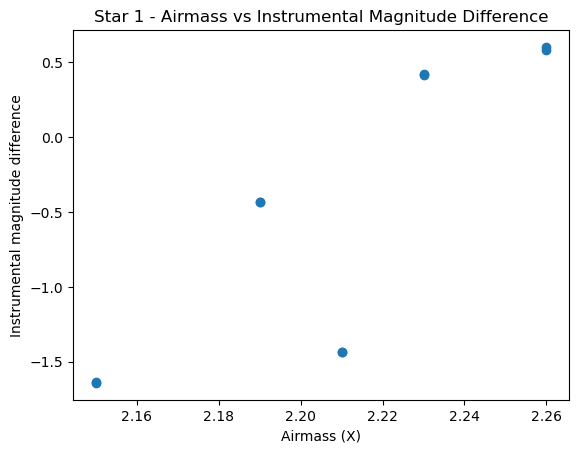

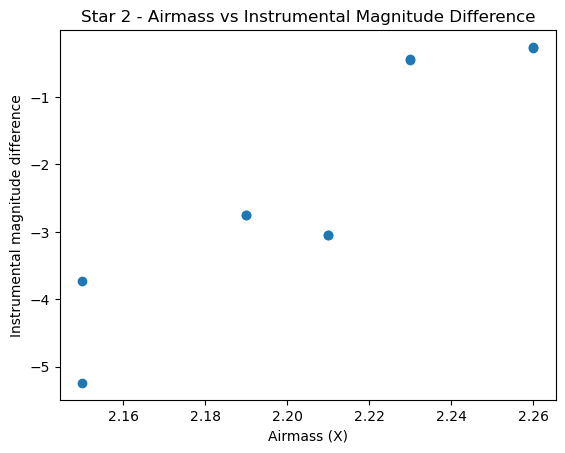

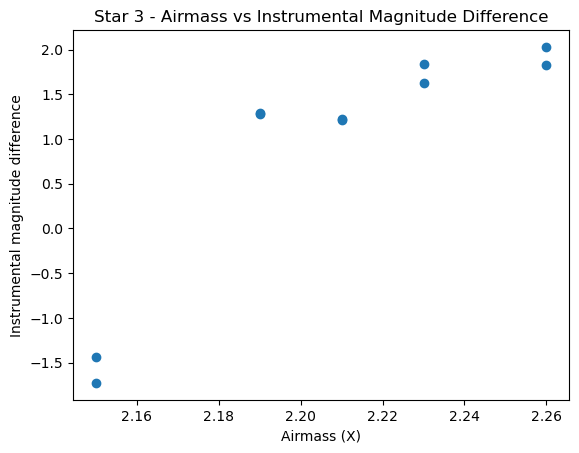

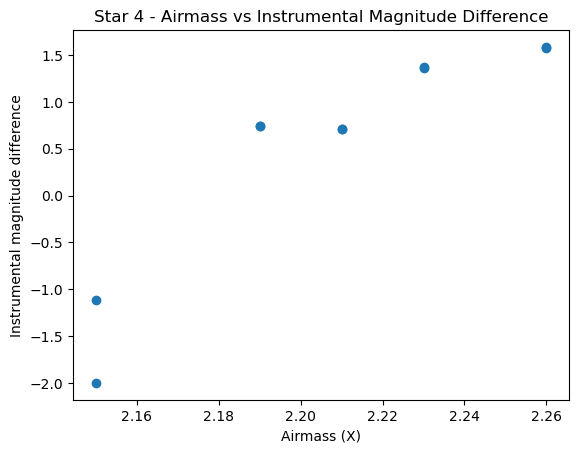

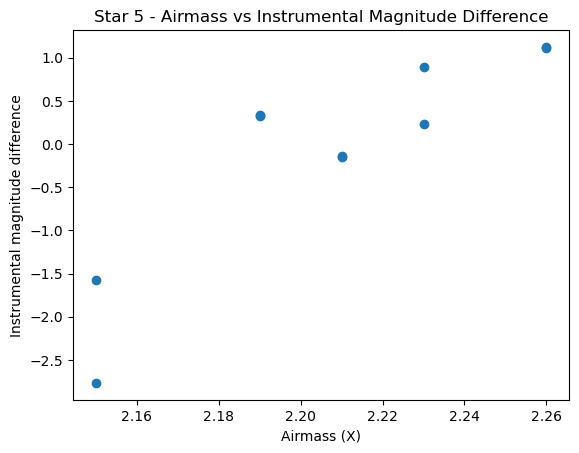

In [273]:
real_mags_lst = [14.397, 15.256, 12.969, 13.229, 13.691]
star_airmass = [[] for _ in range(5)]
star_magdiff = [[] for _ in range(5)]


for res in results:
    star_id = res['star_id'] - 1  # Adjusting index to start from 0
    real_mag = real_mags_lst[star_id]
    star_airmass[star_id].append(res["airmass"])
    star_magdiff[star_id].append(res["instrumental_magnitude"] - real_mag)

for i in range(5):
    plt.scatter(star_airmass[i], star_magdiff[i])
    plt.title(f'Star {i + 1} - Airmass vs Magnitude Difference')
    plt.xlabel('Airmass (X)')
    plt.ylabel('Magnitude difference')
    plt.show()


Now in the following two cells I plotted the magnitude difference and the b - v and v - r for all the sources separately.

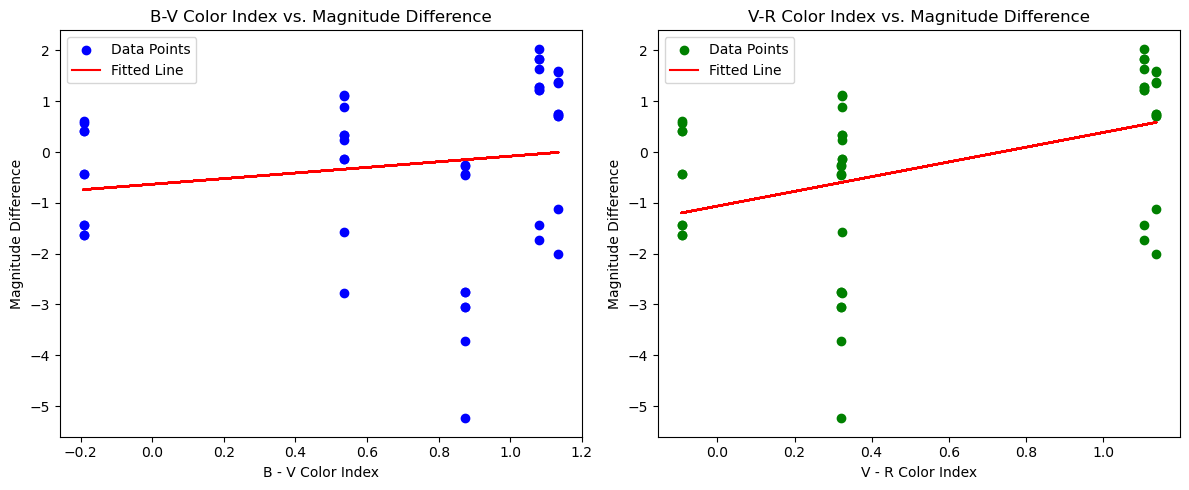

Constant,Slope (First Order Color Term),Intercept (Instrumental Zero Point)
str3,float64,float64
B-V,0.5525698619439616,-0.633883756600879
V-R,1.4479916987976895,-1.0644272753026005


In [289]:
new_data = results

real_mags_lst = [14.397, 15.256, 12.969, 13.229, 13.691]
b_minus_v = [-0.192, 0.873, 1.081, 1.134, 0.535]
v_minus_r = [-0.093, 0.320, 1.107, 1.138, 0.324]

star_magdiff_new = []
b_v_new = []
v_r_new = []


for entry in new_data:
    star_id = entry['star_id'] - 1 
    real_mag = real_mags_lst[star_id]
    b_v_new.append(b_minus_v[star_id])
    v_r_new.append(v_minus_r[star_id])
    star_magdiff_new.append(entry["instrumental_magnitude"] - real_mag)

b_v_new = np.array(b_v_new).reshape(-1, 1)
v_r_new = np.array(v_r_new).reshape(-1, 1)
star_magdiff_new = np.array(star_magdiff_new)

# Linear regression for B-V color index
b_v_model_new = LinearRegression().fit(b_v_new, star_magdiff_new)
b_v_pred_new = b_v_model_new.predict(b_v_new)

# Linear regression for V-R color index
v_r_model_new = LinearRegression().fit(v_r_new, star_magdiff_new)
v_r_pred_new = v_r_model_new.predict(v_r_new)

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(b_v_new, star_magdiff_new, color='blue', label='Data Points')
plt.plot(b_v_new, b_v_pred_new, color='red', label='Fitted Line')
plt.xlabel('B - V Color Index')
plt.ylabel('Magnitude Difference')
plt.title('B-V Color Index vs. Magnitude Difference')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(v_r_new, star_magdiff_new, color='green', label='Data Points')
plt.plot(v_r_new, v_r_pred_new, color='red', label='Fitted Line')
plt.xlabel('V - R Color Index')
plt.ylabel('Magnitude Difference')
plt.title('V-R Color Index vs. Magnitude Difference')
plt.legend()

plt.tight_layout()
plt.show()

# Creating an Astropy table to neatly display the results
table = Table()

table['Constant'] = ['B-V', 'V-R']
table['Slope (First Order Color Term)'] = [b_v_slope_new, v_r_slope_new]
table['Intercept (Instrumental Zero Point)'] = [b_v_intercept_new, v_r_intercept_new]

table


Now we can pick the R filter and I filter files of the NGC6823 file and make a color magnitude diagram of this open cluster.

In [302]:
imgs = ccdp.ImageFileCollection(reduced_dir, glob_include='*otzf.fits')
r_files = imgs.files_filtered(imagetyp='science', OBJECT='ngc6823', filter='R', include_path=True)
i_files = imgs.files_filtered(imagetyp='science', OBJECT='ngc6823', filter='I', include_path=True)

In [327]:
def calculate_instrumental_magnitudes_ngc(file_paths, aperture_radius, annulus_radius):
    """
    Calculates the instrimuntal magnitude of the standard stars in a definite file
    """
    results = []
    for file_path in file_paths:
        with fits.open(file_path) as hdul:
            data = hdul[0].data
            airmass = hdul[0].header.get('AIRMASS', 1.0)
        background_noise = mad_std(data)
        daofind = DAOStarFinder(fwhm=2.0, threshold=5.0 * background_noise)
        filtered_sources = daofind(data - np.median(data))
        positions = np.transpose((filtered_sources['xcentroid'], filtered_sources['ycentroid']))
        aperture = CircularAperture(positions, r=aperture_radius)
        annulus_aperture = CircularAnnulus(positions, r_in=annulus_radius, r_out=annulus_radius+5)
        annulus_masks = annulus_aperture.to_mask(method='center')
        phot_table = aperture_photometry(data, aperture)
        bkg_median = []
        for mask in annulus_masks:
            annulus_data = mask.multiply(data)
            annulus_data_1d = annulus_data[mask.data > 0]
            median_sigclip = np.median(annulus_data_1d)
            bkg_median.append(median_sigclip)
        bkg_median = np.array(bkg_median)
        # Calculate the instrumental magnitude
        annulus_area = annulus_aperture.area
        bkg_sum = bkg_median * annulus_area
        bkg_sum_per_pixel = bkg_sum / aperture.area
        final_sum = phot_table['aperture_sum'] - bkg_sum_per_pixel
        instrumental_magnitude = 2.5 * np.log10(final_sum)
        print(phot_table)
        for idx in range(len(phot_table)):
            star = phot_table[idx]
            results.append({
                'file_path': file_path,
                'star_id': idx+1,
                'airmass': airmass,
                'instrumental_magnitude': instrumental_magnitude[idx]
            })

    return results

In [328]:
aperture_radius = 10
annulus_radius = 30

r_results = calculate_instrumental_magnitudes_ngc(r_files, aperture_radius, annulus_radius)
i_results = calculate_instrumental_magnitudes_ngc(i_files, aperture_radius, annulus_radius)


 id       xcenter            ycenter          aperture_sum   
            pix                pix                           
---- ------------------ ------------------ ------------------
   1 1416.6295715617555 1.7571236360566238 30650.626640882256
   2 1286.8433645147045  6.946553069077694  66070.04505584408
   3  463.8442386277618 7.6794098364925265 23320.383015879022
   4 1130.3523432316192  8.003308568573644  48261.58519941649
   5 264.24465280716606 10.050296720909602  35844.04242635306
   6  397.5841759747517 10.005672747305306 37938.400486199214
   7 1778.7795610746875 10.320599402718486 33318.454906691826
   8  2017.812950180121  10.23262731355453  29803.81541025605
   9  72.47069242986025   14.0197399240494   23448.1738262216
  10 1132.2247436900022 14.905004442510801 47517.648441373276
 ...                ...                ...                ...
1772 1931.9965763445687 2034.3342804273873  63316.73891501346
1773 179.85157912496172 2036.6218741366736 29039.425005994843
1774  55

In [320]:
print(i_files)

['Imaging.reduced/a153otzf.fits', 'Imaging.reduced/a154otzf.fits']


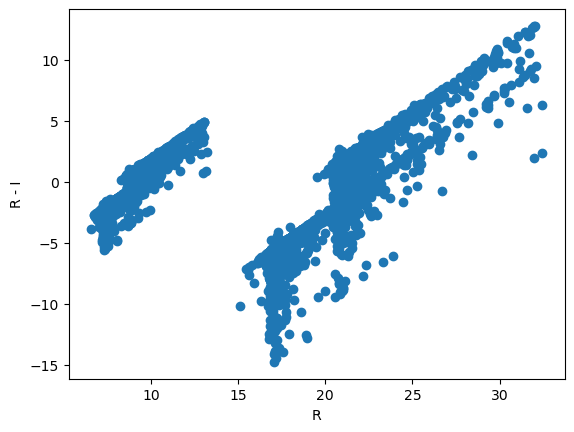

In [331]:
r = []
r_i = []

for s in range(len(r_results)):
    i_res = i_results[s]
    r_res = r_results[s]
    r_res = r_res['instrumental_magnitude']/table["Slope (First Order Color Term)"] - table["Intercept (Instrumental Zero Point)"]
    i_res = i_res['instrumental_magnitude']/table["Slope (First Order Color Term)"] - table["Intercept (Instrumental Zero Point)"]
    r.append(r_res)
    r_i.append(r_res - i_res)

plt.scatter(r, r_i)
plt.xlabel("R")
plt.ylabel("R - I")
plt.show()

Looks weird! Might be some mistakes in step 6